In [72]:
# Some code is shamelessly copied from Learning Blogs
%matplotlib inline
import numpy as np
import pandas as pd
from pandas import Series
from pandas import DataFrame
from pandas import concat
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from pylab import rcParams
import math
import zipfile
from datetime import datetime
from dateutil import parser
import datetime
import random

pd.set_option('display.max_columns', None)
rcParams['figure.figsize'] = 15, 5


def parseDate(d):
    try:
        return parser.parse(d)        
    except:
        return None

def maxD(v):
    dt1 = parseDate(v[0])
    dt2 = parseDate(v[1])
    if dt1 is not None and dt2 is not None:
        return max(dt1, dt2)
    elif dt1 is not None:
        return dt1
    else:
        return dt2
    
def addDelta(v):
    delta = datetime.timedelta(0,random.randint(1, 15), random.randint(1, 1001))
    dt = parseDate(str(v[0]))
    if dt is not None:
        return dt+delta
    else:
        return dt
    

    
def num(s):
    try:
        return int(s[0])
    except ValueError:
        return float(s[0])
    except ValueError:
        return None

def differ(v):
    d1 = num(v[0])
    d2 = num(v[1])
    if d1 is not None and d2 is not None and abs(d1-d2)<=10:
        return False
    else:
        return True
    
def pererr(err, avg):
    return (err/avg)*100

def mean(l):
    return reduce(lambda x, y: x + y, l) / len(l)

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff)


# invert differenced value
def inverse_difference(history, pred, interval=1):
    return pred + history[-interval]

    
def predict(coef, history):
    pred = 0.0
    for i in range(1, len(coef)+1):
        pred += coef[i-1] * history[-i]
    return pred    

# runArimaForTS takes a pandas.Series with dateIndex and T as number of Test Points, (ar, i, ma) as arima params 
def runArimaForTs(series, T, ar, i, ma):
    X = series.values
    size = len(X) - T
    train, test = X[0:size], X[size:]
    history = [x for x in train]
    predictions = list()
    errs = []
    for t in range(len(test)):
        model = ARIMA(history, order=(ar,i,ma))
        model_fit = model.fit(disp=False)
        ar_coef, ma_coef = model_fit.arparams, model_fit.maparams
        resid = model_fit.resid
        diff = difference(history)
        pred = history[-1] + predict(ar_coef, diff) + predict(ma_coef, resid)
        predictions.append(pred)
        obs = test[t]
        history.append(obs)
        err=pererr(abs(obs-pred),obs)
        errs.append(err)
        print('>predicted=%.3f, expected=%.3f, err=%.3f' % (pred, obs, err))
    rmse = sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    print('Test RMSE: %.3f, MAE:%.3f, Err:%.3f'% (rmse, mae, mean(errs)))
    acts =Series(test, series.index[size:])
    preds=Series(predictions, series.index[size:])
    preds.plot(color="red", label="Prediction")
    acts.plot(color="blue", label="Expected")
    return (predictions, test)
 
    # runArimaForTS takes a pandas.Series with dateIndex and T as number of Test Points, (ar, i, ma) as arima params 
def runArimaForTs2(series, T, I, ar, i, ma):
    X = series.values
    size = len(X) - T
    train, test = X[0:size], X[size:]
    history = [x for x in train]
    predictions = list()
    errs = []
    for t in range(len(test)):
        differenced = difference(history, I)
        model = ARIMA(differenced, order=(ar,i,ma))
        model_fit = model.fit(disp=False)
        # one-step out-of sample forecast
        pred = model_fit.forecast()[0]
        # invert the differenced forecast
        pred = inverse_difference(history, pred, I)
        print pred, test
        predictions.append(pred)
        obs = test[t]
        history.append(obs)
        err=pererr(abs(obs-pred),obs)
        errs.append(err)
        print('>predicted=%.3f, expected=%.3f, err=%.3f' % (pred, obs, err))
    rmse = sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    print('Test RMSE: %.3f, MAE:%.3f, Err:%.3f'% (rmse, mae, mean(errs)))
    acts =Series(test, series.index[size:])
    preds=Series(predictions, series.index[size:])
    #preds.plot(color="red", label="Prediction")
    #acts.plot(color="blue", label="Expected")
    return (predictions, test , preds, acts)
 

In [34]:
zf = zipfile.ZipFile('data/order-reports_05_09_2017_23_16.csv.zip') 
kp = pd.read_csv(zf.open('order-reports_05_09_2017_23_16.csv'), header=0)

In [35]:
kpi=kp.iloc[:, 
          [0, 2, 6, 7, 8, 9, 10, 11, 14, 20, 22, 
           37, 38, 39, 75, 41, 93, 95]]
kpi.count()


Id                     6626
Customer Name          6626
From City              6626
To City                6626
Distance               6625
From Sublocation       6626
To Sublocation         6626
Order Value            5143
Used truck Type        5134
Warehouse Start Loc    6626
Warehouse End Loc      6626
Sector Name            6626
Tonnage                5102
Per Ton Rate           2876
Product Name           6626
Freight Amount         5126
Order Accepted         4361
Order Blocked          1689
dtype: int64

In [36]:
# Picking earliest of Order Accepted or Order Blocked date as Order Date
kpi['date']=kpi[['Order Accepted', 'Order Blocked']].apply(maxD, axis=1)
#kpi.drop(['Order Accepted', 'Order Blocked'], axis=1, inplace=True)
kpi.count()

/Library/Python/2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Id                     6626
Customer Name          6626
From City              6626
To City                6626
Distance               6625
From Sublocation       6626
To Sublocation         6626
Order Value            5143
Used truck Type        5134
Warehouse Start Loc    6626
Warehouse End Loc      6626
Sector Name            6626
Tonnage                5102
Per Ton Rate           2876
Product Name           6626
Freight Amount         5126
Order Accepted         4361
Order Blocked          1689
date                   6033
dtype: int64

In [37]:
## Checking how much bad Values/Rows we have
kpi[(pd.isnull(kpi['Freight Amount'])==False) & (pd.isnull(kpi['Order Value'])==False)].count()

Id                     5126
Customer Name          5126
From City              5126
To City                5126
Distance               5126
From Sublocation       5126
To Sublocation         5126
Order Value            5126
Used truck Type        5126
Warehouse Start Loc    5126
Warehouse End Loc      5126
Sector Name            5126
Tonnage                4283
Per Ton Rate           2876
Product Name           5126
Freight Amount         5126
Order Accepted         3517
Order Blocked          1626
date                   5126
dtype: int64

In [38]:
# droping all rows where we don't know about date (i.e date is null)
kpi = kpi[pd.isnull(kpi['date'])==False]
kpi.count()

Id                     6033
Customer Name          6033
From City              6033
To City                6033
Distance               6033
From Sublocation       6033
To Sublocation         6033
Order Value            5143
Used truck Type        5134
Warehouse Start Loc    6033
Warehouse End Loc      6033
Sector Name            6033
Tonnage                5102
Per Ton Rate           2876
Product Name           6033
Freight Amount         5126
Order Accepted         4361
Order Blocked          1689
date                   6033
dtype: int64

In [39]:
# calculating per unit km per ton price for the lane
kpi['ptr'] = (kpi['Freight Amount']/(kpi['Tonnage']*(kpi['Distance']/1000)))


In [40]:
# check whether we have duplicate dates
kpi['date'].unique().size

5435

In [41]:
# how many duplicates we have
kpi[kpi.date.duplicated()].count()

Id                     598
Customer Name          598
From City              598
To City                598
Distance               598
From Sublocation       598
To Sublocation         598
Order Value            481
Used truck Type        480
Warehouse Start Loc    598
Warehouse End Loc      598
Sector Name            598
Tonnage                555
Per Ton Rate           384
Product Name           598
Freight Amount         480
Order Accepted         575
Order Blocked           24
date                   598
ptr                    445
dtype: int64

In [42]:
# Lets try to make d as unique as possible by adding some secs, ms
kpi['d'] = kpi[['date']].apply(addDelta, axis=1)

In [43]:
kpi['d'].unique().size
# should come around the count of rows we have

6033

In [44]:
# Lets Group By by ('From City', 'From Sublocation', 'To City', 'To Sublocation', 'Used truck Type', 'Product Name')
kpi.groupby(['From City', 'From Sublocation', 'To City', 'To Sublocation', 'Used truck Type', 'Product Name']).count().nlargest(10, 'Id')

Id  \
From City From Sublocation To City       To Sublocation Used truck Type Product Name          
Anjar     Lilashah Nagar   Agra          Dholpur House  27T/28T         Packaged Foods  284   
          Kandla           Pathankot     Pathankot      30 MT           Coal            189   
                           Vallabhnagar  Dabok          30 MT           Coal            149   
                           Dholka        Dholka         30 MT           Coal            114   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Oil             110   
          Kandla           Pune          Kurkumbh       21T/20T         Agriculture      95   
          Gandhidham       Panipat       Panipat        27T/28T         Textiles         94   
          Dhaneti          Sinnar        Vijay Nagar    21T/20T         Non-metals       91   
          Kandla           Karnal        Karnal         27T/28T         Oil              89   
                           Muzaffarnagar Muzaffarnagar  34T             Coal             88   

                                                                                        Customer Name  \
From City From Sublocation To City       To Sublocation Used truck Type Product Name                    
Anjar     Lilashah Nagar   Agra          Dholpur House  27T/28T         Packaged Foods            284   
          Kandla           Pathankot     Pathankot      30 MT           Coal                      189   
                           Vallabhnagar  Dabok          30 MT           Coal                      149   
                           Dholka        Dholka         30 MT           Coal                      114   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Oil                       110   
          Kandla           Pune          Kurkumbh       21T/20T         Agriculture                95   
          Gandhidham       Panipat       Panipat        27T/28T         Textiles                   94   
          Dhaneti          Sinnar        Vijay Nagar    21T/20T         Non-metals                 91   
          Kandla           Karnal        Karnal         27T/28T         Oil                        89   
                           Muzaffarnagar Muzaffarnagar  34T             Coal                       88   

                                                                                        Distance  \
From City From Sublocation To City       To Sublocation Used truck Type Product Name               
Anjar     Lilashah Nagar   Agra          Dholpur House  27T/28T         Packaged Foods       284   
          Kandla           Pathankot     Pathankot      30 MT           Coal                 189   
                           Vallabhnagar  Dabok          30 MT           Coal                 149   
                           Dholka        Dholka         30 MT           Coal                 114   
          Lilashah Nagar   Agra          Dholpur House  27T/28T         Oil                  110   
          Kandla           Pune          Kurkumbh       21T/20T         Agriculture           95   
          Gandhidham       Panipat       Panipat        27T/28T         Textiles              94   
          Dhaneti          Sinnar        Vijay Nagar    21T/20T         Non-metals            91   
          Kandla           Karnal        Karnal         27T/28T         Oil                   89   
                           Muzaffarnagar Muzaffarnagar  34T             Coal                  88   

                                                                                        Order Value  \
From City From Sublocation To City       To Sublocation Used truck Type Product Name                  
Anjar     Lilashah Nagar   Agra          Dholpur House  27T/28T         Packaged Foods          283   
          Kandla           Pathankot     Pathankot      30 MT           Coal                    189   
                           Vallabhnagar  Dabok          30 MT           Co

In [45]:
# Group by From City
kpi.groupby(['From City']).count().nlargest(10, 'Id')

,Id,Customer Name,To City,Distance,From Sublocation,To Sublocation,Order Value,Used truck Type,Warehouse Start Loc,Warehouse End Loc,Sector Name,Tonnage,Per Ton Rate,Product Name,Freight Amount,Order Accepted,Order Blocked,date,ptr,d
From City,,,,,,,,,,,,,,,,,,,,
Anjar,6033,6033,6033,6033,6033,6033,5143,5134,6033,6033,6033,5102,2876,6033,5126,4361,1689,6033,4283,6033


In [46]:
# Let's work out on Top 3 lane based on count of orders
s1 = kpi[(kpi['From Sublocation']=='Kandla') & (kpi['To Sublocation']=='Pathankot') & (kpi['Used truck Type']=='30 MT') & (kpi['Product Name']=='Coal')]
s2 = kpi[(kpi['From Sublocation']=='Kandla') & (kpi['To Sublocation']=='Dabok') & (kpi['Used truck Type']=='30 MT') & (kpi['Product Name']=='Coal')]
s3 = kpi[(kpi['From Sublocation']=='Kandla') & (kpi['To Sublocation']=='Dholka') & (kpi['Used truck Type']=='30 MT') & (kpi['Product Name']=='Coal')]
# We are droping Anjar-Agra as there is no info about Tonnage, we will see it later on
s4 = kpi[(kpi['From Sublocation']=='Lilashah Nagar') & (kpi['To Sublocation']=='Dholpur House') & (kpi['Used truck Type']=='27T/28T') & (kpi['Product Name']=='Packaged Foods')]

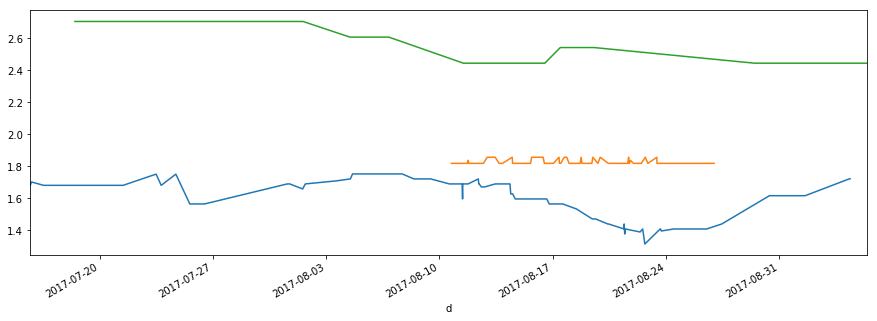

In [47]:
# per km per ton price for the shorter lane is higher than longer lanes 
# that may be inferred due to fixed cost of driver
s = [s1, s2, s3]
sp = [Series(x['ptr'].values, index=x['d']) for x in s]
[x.plot() for x in sp]



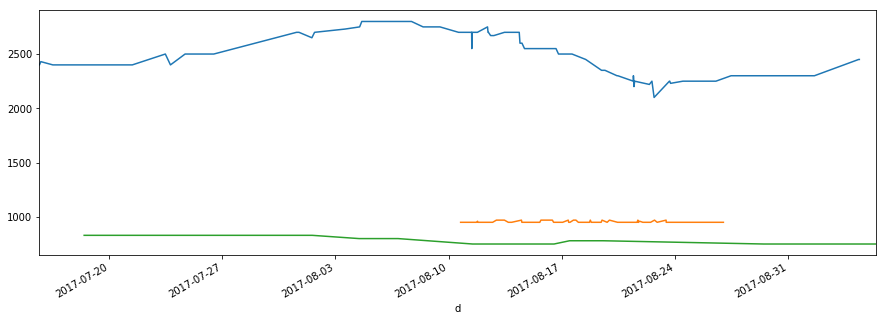

In [48]:
s = [s1, s2, s3]
s = [Series(x['Per Ton Rate'].values, index=x['d']) for x in s]
[x.plot(label="sdfa") for x in s]

In [49]:
# lets try to run some models now
# Let's resample series into 1day bucket and filling missing values by mean
s_fna = [x.resample("1d").mean().fillna(method="ffill") for x in s]
s_len = [len(x) for x in s]
print s_len
s_len = [len(x) for x in s_fna]
print s_len

[189, 149, 114]
[52, 17, 50]


>predicted=2697.488, expected=2614.286, err=3.183
>predicted=2616.085, expected=2614.286, err=0.069
>predicted=2620.268, expected=2542.308, err=3.067
>predicted=2530.152, expected=2500.000, err=1.206
>predicted=2486.349, expected=2450.000, err=1.484
>predicted=2424.972, expected=2350.000, err=3.190
>predicted=2315.886, expected=2300.000, err=0.691
>predicted=2259.033, expected=2250.000, err=0.401
>predicted=2201.829, expected=2184.000, err=0.816
>predicted=2139.768, expected=2243.333, err=4.617
>predicted=2217.361, expected=2250.000, err=1.451
>predicted=2238.978, expected=2250.000, err=0.490
>predicted=2260.827, expected=2250.000, err=0.481
>predicted=2253.118, expected=2300.000, err=2.038
>predicted=2304.880, expected=2300.000, err=0.212
>predicted=2306.839, expected=2300.000, err=0.297
>predicted=2311.295, expected=2300.000, err=0.491
>predicted=2302.415, expected=2300.000, err=0.105
>predicted=2300.365, expected=2300.000, err=0.016
>predicted=2299.889, expected=2300.000, err=0.005


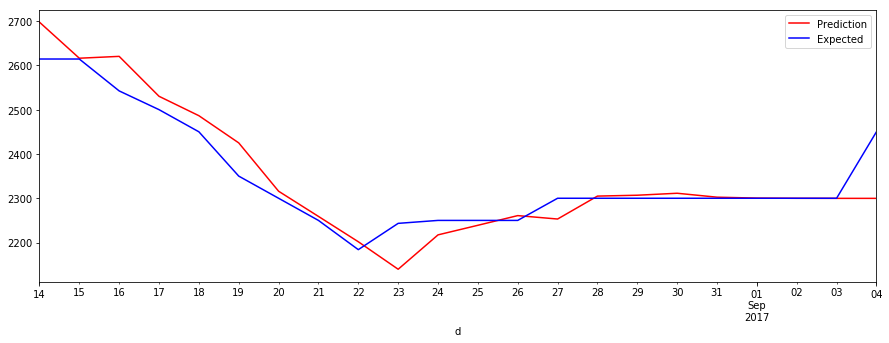

In [51]:
pred, act = runArimaForTs(s_fna[0], 22, 3, 1, 1 )
plt.legend()


>predicted=2700.529, expected=2614.286, err=3.299
>predicted=2610.099, expected=2614.286, err=0.160
>predicted=2609.998, expected=2542.308, err=2.663
>predicted=2511.104, expected=2500.000, err=0.444
>predicted=2465.461, expected=2450.000, err=0.631
>predicted=2405.846, expected=2350.000, err=2.376
>predicted=2295.764, expected=2300.000, err=0.184
>predicted=2239.138, expected=2250.000, err=0.483
>predicted=2182.418, expected=2184.000, err=0.072
>predicted=2119.015, expected=2243.333, err=5.542
>predicted=2200.874, expected=2250.000, err=2.183
>predicted=2223.407, expected=2250.000, err=1.182
>predicted=2246.593, expected=2250.000, err=0.151
>predicted=2235.507, expected=2300.000, err=2.804
>predicted=2295.784, expected=2300.000, err=0.183
>predicted=2299.281, expected=2300.000, err=0.031
>predicted=2303.012, expected=2300.000, err=0.131
>predicted=2290.817, expected=2300.000, err=0.399
>predicted=2291.112, expected=2300.000, err=0.386
>predicted=2291.590, expected=2300.000, err=0.366


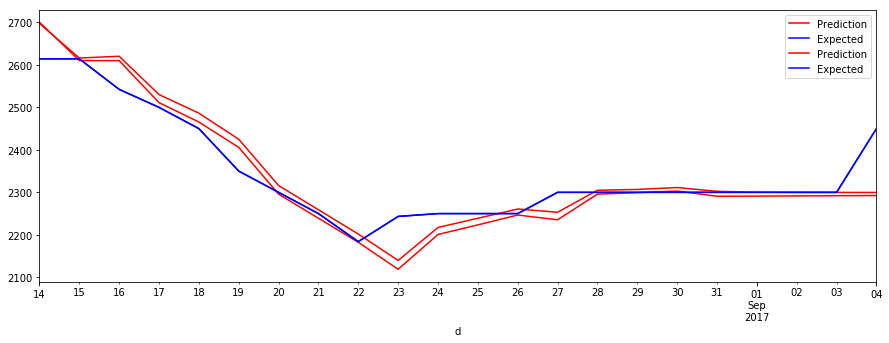

In [88]:
# runArimaForTS takes a pandas.Series with dateIndex and T as number of Test Points, (ar, i, ma) as arima params 
def runArimaForTs2(series, T, I, ar, i, ma):
    X = series.values
    size = len(X) - T
    train, test = X[0:size], X[size:]
    history = [x for x in train]
    predictions = list()
    errs = []
    for t in range(len(test)):
        differenced = difference(history, I)
        model = ARIMA(differenced, order=(ar,i,ma))
        model_fit = model.fit(disp=False)
        # one-step out-of sample forecast
        pred = (model_fit.forecast()[0][0])
        # invert the differenced forecast
        pred = inverse_difference(history, pred, I)
        predictions.append(pred)
        obs = test[t]
        history.append(obs)
        err=pererr(abs(obs-pred),obs)
        errs.append(err)
        print('>predicted=%.3f, expected=%.3f, err=%.3f' % (pred, obs, err))
    rmse = sqrt(mean_squared_error(test, predictions))
    mae = mean_absolute_error(test, predictions)
    print('Test RMSE: %.3f, MAE:%.3f, Err:%.3f'% (rmse, mae, mean(errs)))
    acts =Series(test, series.index[size:])
    preds=Series(predictions, series.index[size:])
    preds.plot(color="red", label="Prediction")
    acts.plot(color="blue", label="Expected")
    return (predictions, test)

In [71]:
act

array([ 2614.28571429,  2614.28571429,  2542.30769231,  2500.        ,
        2450.        ,  2350.        ,  2300.        ,  2250.        ,
        2184.        ,  2243.33333333,  2250.        ,  2250.        ,
        2250.        ,  2300.        ,  2300.        ,  2300.        ,
        2300.        ,  2300.        ,  2300.        ,  2300.        ,
        2300.        ,  2450.        ])

>predicted=952.944, expected=950.000, err=0.310
Test RMSE: 2.944, MAE:2.944, Err:0.310


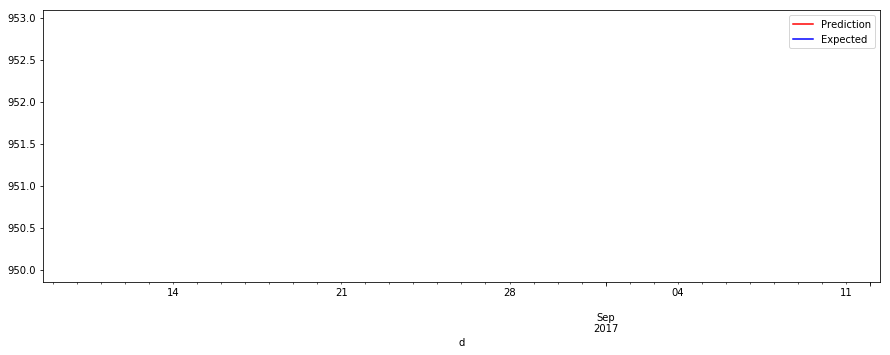

In [55]:
pred, act = runArimaForTs(s_fna[1], 1, 3, 1, 1 )
plt.legend()

>predicted=749.047, expected=750.000, err=0.127
>predicted=749.026, expected=750.000, err=0.130
>predicted=748.906, expected=780.000, err=3.986
>predicted=778.347, expected=780.000, err=0.212
>predicted=778.179, expected=780.000, err=0.234
>predicted=775.567, expected=780.000, err=0.568
>predicted=775.707, expected=780.000, err=0.550
>predicted=775.903, expected=780.000, err=0.525
>predicted=776.083, expected=780.000, err=0.502
>predicted=776.247, expected=780.000, err=0.481


/Library/Python/2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


>predicted=776.398, expected=780.000, err=0.462
>predicted=776.538, expected=780.000, err=0.444
>predicted=776.666, expected=780.000, err=0.427
>predicted=776.786, expected=780.000, err=0.412
>predicted=776.897, expected=750.000, err=3.586
>predicted=747.861, expected=750.000, err=0.285
>predicted=747.278, expected=750.000, err=0.363
>predicted=749.343, expected=750.000, err=0.088
>predicted=749.067, expected=750.000, err=0.124
>predicted=748.775, expected=750.000, err=0.163
>predicted=748.502, expected=750.000, err=0.200
>predicted=748.248, expected=750.000, err=0.234
Test RMSE: 9.168, MAE:4.928, Err:0.641


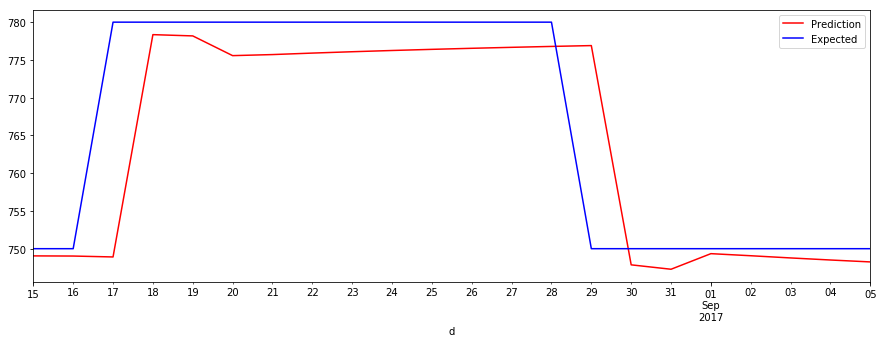

In [57]:
pred, act = runArimaForTs(s_fna[2], 22, 3, 1, 1 )
plt.legend()